In [1]:
%matplotlib inline

In [2]:
# Cell 1 — Install Required Libraries
!pip install librosa soundfile numpy scikit-learn matplotlib IPython pandas


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
#Cell 2 — Imports

import librosa
import numpy as np
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
# Cell 3 — Load Dataset (Your Provided Table)

data = {
    "clip_id": [
        "AC_001","AC_002","AC_003",
        "CH_001","CH_002","CH_003",
        "CP_001","CP_002","CP_003",
        "DB_001","DB_002","DB_003",
        "DR_001","DR_002","DR_003",
        "EI_001","EI_002","EI_003",
        "GS_001","GS_002","GS_003",
        "JH_001","JH_002","JH_003",
        "SR_001","SR_002","SR_003",
        "SM_001","SM_002","SM_003"
    ],
    "class_label": [
        "air_conditioner","air_conditioner","air_conditioner",
        "car_horn","car_horn","car_horn",
        "children_playing","children_playing","children_playing",
        "dog_bark","dog_bark","dog_bark",
        "drilling","drilling","drilling",
        "enginge_idling","enginge_idling","enginge_idling",
        "gun_shot","gun_shot","gun_shot",
        "jackhammer","jackhammer","jackhammer",
        "siren","siren","siren",
        "street_music","street_music","street_music"
    ],
    "duration_sec": [
        3.2,2.9,3.5,
        1.4,1.6,1.2,
        3.9,3.4,3.8,
        1.5,1.8,1.6,
        3.6,3.2,3.8,
        3.7,3.9,3.5,
        0.8,1.0,0.9,
        3.8,3.6,3.9,
        3.7,3.5,3.9,
        3.9,3.6,3.8
    ],
    "augmentation_type": [
        "background_noise","pitch_shift","speed_change",
        "speed_change","background_noise","pitch_shift",
        "background_noise","speed_change","pitch_shift",
        "pitch_shift","background_noise","speed_change",
        "background_noise","pitch_shift","speed_change",
        "speed_change","background_noise","pitch_shift",
        "background_noise","pitch_shift","speed_change",
        "pitch_shift","background_noise","speed_change",
        "speed_change","pitch_shift","background_noise",
        "background_noise","pitch_shift","speed_change"
    ],
    "noise_level_db": [
        -18,0,0,
        0,-20,0,
        -18,0,0,
        0,-22,0,
        -15,0,0,
        0,-20,0,
        -25,0,0,
        0,-18,0,
        0,0,-20,
        -18,0,0
    ],
    "pitch_shift_semitones": [
        0,-2,0,
        0,0,1,
        0,0,1,
        1,0,0,
        0,-1,0,
        0,0,-1,
        0,1,0,
        -1,0,0,
        0,1,0,
        0,1,0
    ],
    "speed_factor": [
        1,1,0.95,
        1.1,1,1,
        1,1.05,1,
        1,1,0.9,
        1,1,1.05,
        0.9,1,1,
        1,1,0.95,
        1,1,1.05,
        1.05,1,1,
        1,1,0.95
    ]
}

df = pd.DataFrame(data)
df.head()

,clip_id,class_label,duration_sec,augmentation_type,noise_level_db,pitch_shift_semitones,speed_factor
0,AC_001,air_conditioner,3.2,background_noise,-18,0,1.00
1,AC_002,air_conditioner,2.9,pitch_shift,0,-2,1.00
2,AC_003,air_conditioner,3.5,speed_change,0,0,0.95
3,CH_001,car_horn,1.4,speed_change,0,0,1.10
4,CH_002,car_horn,1.6,background_noise,-20,0,1.00


In [5]:
# Cell 4 — Generate Base Synthetic Audio

def generate_base_tone(duration, sr=22050, freq=220):
    t = np.linspace(0, duration, int(sr * duration), False)
    tone = 0.5 * np.sin(2 * np.pi * freq * t)
    return tone, sr

generated_clips = {}

for _, row in df.iterrows():
    audio, sr = generate_base_tone(row["duration_sec"])
    generated_clips[row["clip_id"]] = audio

In [6]:
# Cell 5 — Augmentation Functions

def add_background_noise(audio, noise_db=-20):
    noise = np.random.randn(len(audio))
    noise = noise * (10 ** (noise_db / 20))
    return audio + noise

def apply_pitch_shift(audio, sr, semitones):
    # librosa 0.10+ requires keyword arguments
    return librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=semitones)

def apply_speed_change(audio, factor):
    # librosa 0.10+ requires keyword arguments
    return librosa.effects.time_stretch(y=audio, rate=factor)

In [7]:
# Cell 6 — Apply Augmentation Based on Metadata
processed_clips = {}

processed_clips = {}

for _, row in df.iterrows():
    clip = generated_clips[row["clip_id"]]
    
    if row["augmentation_type"] == "background_noise":
        clip = add_background_noise(clip, row["noise_level_db"])
        
    elif row["augmentation_type"] == "pitch_shift":
        clip = apply_pitch_shift(clip, sr, row["pitch_shift_semitones"])
        
    elif row["augmentation_type"] == "speed_change":
        clip = apply_speed_change(clip, row["speed_factor"])
        # Fix length mismatch after time-stretch
        target_len = len(generated_clips[row["clip_id"]])
        if len(clip) > target_len:
            clip = clip[:target_len]
        else:
            clip = np.pad(clip, (0, target_len - len(clip)))
    
    processed_clips[row["clip_id"]] = clip

In [13]:
# Cell 7 — Play Any Audio Clip

def play_clip(clip_id):
    audio = processed_clips[clip_id]
    display(ipd.Audio(audio, rate=sr))

# Test it
play_clip("CH_001")

In [9]:
# Cell 8 — Extract MFCC Features

def extract_mfcc(audio, sr):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    return mfcc.mean(axis=1)

X = []
y = []

for _, row in df.iterrows():
    clip = processed_clips[row["clip_id"]]
    X.append(extract_mfcc(clip, sr))
    y.append(row["class_label"])

In [10]:
# Cell 9 — Train Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)

print("Model Accuracy:", accuracy)
accuracy  # ensures output appears

Model Accuracy: 0.0


0.0

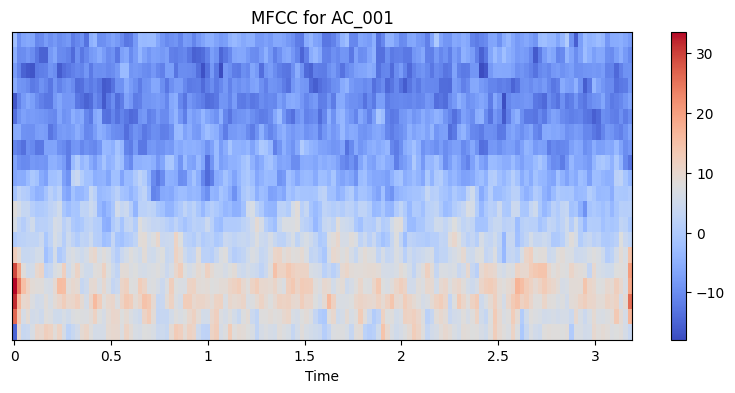

In [11]:
# Cell 10 — Visualize MFCC for a Sample Clip

import librosa.display

sample_id = "AC_001"
sample_audio = processed_clips[sample_id]
mfcc = librosa.feature.mfcc(y=sample_audio, sr=sr, n_mfcc=20)

plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title(f"MFCC for {sample_id}")
plt.show()

Notebook output is working!


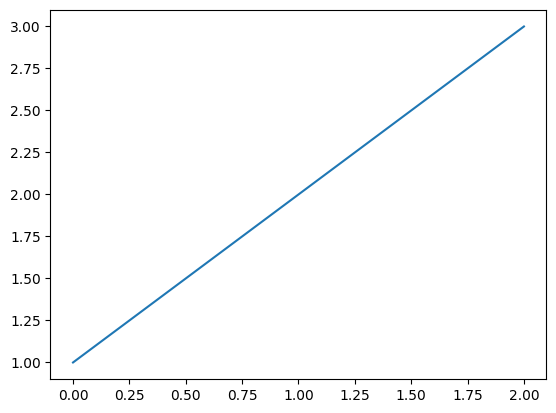

In [12]:
print("Notebook output is working!")
plt.plot([1,2,3])
plt.show()
ipd.Audio(np.sin(np.linspace(0, 440, 22050)), rate=22050)